In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0] - pt[1]) / 1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy():
    inputs = []
    labels = []
    
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        
        if 0.1*i == 0.5:
            continue
            
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
        
    return np.array(inputs), np.array(labels).reshape(21, 1)

def show_dataset(x1, y1, x2, y2 ):
    plt.subplot(1,2,1)
    plt.title('Linear', fontsize=18)
    for i in range(x1.shape[0]):
        if y1[i] == 0:
            plt.plot(x1[i][0], x1[i][1], 'ro')
        else:
            plt.plot(x1[i][0], x1[i][1], 'bo')
    plt.subplot(1,2,2)
    plt.title('XOR', fontsize=18)
    for i in range(x2.shape[0]):
        if y2[i] == 0:
            plt.plot(x2[i][0], x2[i][1], 'ro')
        else:
            plt.plot(x2[i][0], x2[i][1], 'bo')
    plt.show()

def show_result(x, y, pred_y, history, idx=0):
    pred_y = np.round(pred_y.copy())
    cm = LinearSegmentedColormap.from_list(
        'mymap', [(1, 0, 0), (0, 0, 1)], N=2)
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.title('Ground truth', fontsize=18)
    plt.scatter(x[:,0], x[:,1], c=y[:,0], cmap=cm)
    
    plt.subplot(1,3,2)
    plt.title('Predict result', fontsize=18)
    plt.scatter(x[:,0], x[:,1], c=pred_y[:,0], cmap=cm)
    
    epoch = np.array([i[0] for i in history])
    loss = np.array([i[1] for i in history])
    plt.subplot(1,3,3)
    plt.title('Learning Curve', fontsize=18)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epoch, loss)
    plt.savefig(f'fig/lab01_{idx}.png')
    
    plt.show()

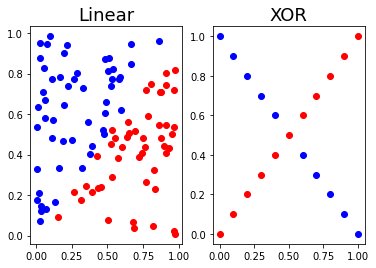

In [3]:
x1, y1 = generate_linear(n=100)
x2, y2 = generate_XOR_easy()
show_dataset(x1, y1, x2, y2)

## Basic Idea

We are trying to find the best network parameters $\theta\{w_1, w_2, w_3,...,b_1,b_2\}$ that minimize the loss $L$ .  When we get the gradient  $\nabla L$ , update the network paramter $w$ by Gradient Descent. 

## Gradient Descent

Actually we have a lot of $\nabla L$, it is a vector : <br>
$$\begin{equation}	\begin{bmatrix}	 \frac{\partial{L(\theta)}}{\partial{w_1}}\\\frac{\partial{L(\theta)}}{\partial{w_2}}\\.\\.\\.\\\frac{\partial{L(\theta)}}{\partial{b_1}}\end{bmatrix}\end{equation}$$<br>
Then compute $\nabla L(\theta^{0}),\nabla L(\theta^{1}),\nabla L(\theta^{2})...$ <br>
Update the $\theta$ , $\theta^{1}=\theta^{0}-\eta\nabla L(\theta^{0})$, we get new $\theta^{1}$.

# Compute $\nabla L$

![title](fig/fig0.png)

$L(\theta)=\sum_{n=1}^{N}C^n(\theta)$ , where $C^n$ is the distance between $y_{pred},y_{gt}$ <br>
Then do the partial to all parameters, we get : <br>
$$\frac{\partial{L(\theta)}}{\partial{w}}=\sum_{n=1}^{N}\frac{\partial{C^{n}(\theta)}}{\partial{w}}$$<br>
Next, we will focus on how to compute $\frac{\partial{C^{n}(\theta)}}{\partial{w}}$.

## Chain Rule

$$\frac{\partial{C}}{\partial{w}}=\frac{\partial{z}}{\partial{w}}\frac{\partial{C}}{\partial{z}}$$

### Forward Pass

![title](fig/fig1.png)

Compute $\frac{\partial{z}}{\partial{w}}$ for all parameters. <br>
$$\frac{\partial{z}}{\partial{w}}=x_1$$

### Backward Pass

Compute $\frac{\partial{C}}{\partial{z}}$ for all activation function inputs $z$. <br>
Use Chain rule again : <br>
$$\frac{\partial{C}}{\partial{z}}=\frac{\partial{a}}{\partial{z}}\frac{\partial{C}}{\partial{a}}$$ <br>
It is easy to compute the first term : <br>
$$\frac{\partial{a}}{\partial{z}}=\sigma'(z)$$ <br>
The difficult part is the second term that we have to concern about two cases : <br>
- output → hidden
- hidden → hidden

In this part, we have to start from the "known parameters". So we will do the "output → hidden" case fisrt. <br>
$$ \frac{\partial C}{\partial z} = L'(y, \hat{y}) $$ <br>
Now that we know the gradient of "output → hidden", we can continue to derive the previous layer "hidden → hidden" <br>
As the figure shown, we can now compute the output of previous node, then we get the backward gradient : <br>
$$\frac{\partial{C}}{\partial{z}}=\sigma '(z)[w_3\frac{\partial{C}}{\partial{z'}}+w_4\frac{\partial{C}}{\partial{z''}}]$$

![title](fig/fig2.png)

# Implement

## Requirements
1. Implement simple neural networks with two hidden layers. 

- hidden layer 1st : <br>
As the figure showing, I design the network architecture use 2 hidden layer with each 4 neurons.<br>
The training data points are $(x_1, x_2)$, so there will be two value feed input the first hidden layer, we make the input shape of first layer is 2, and output for next layer with 4 neurons. We figure out the shape of first hidden layer is (2, 4).
- hidden layer 2nd : <br>
After forwarding pass the first hidden layer, the ouput $a=\sigma(z)$ is a scalar, which means there will be only one value ouput in each neuron, but there are 4 neurons in first hidden layer, we have to design the input size of second layer as 4.
At last, ouput one answer to the output layer, so the shape of second hidden layer is (4, 1).

![title](fig/fig3.png)

In [4]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def derivative_sigmoid(x):
    return np.multiply(x, 1.0 - x)

def MSE(y, y_hat):
    return np.mean((y - y_hat)**2)
    
def derivative_loss(y, y_hat):
    return (y - y_hat)*(2/y.shape[0])

In [5]:
class layer():
    def __init__(self, input_size, output_size) -> None:
        # neuron
        self.w = np.random.normal(0, 1, (input_size, output_size))
        self.gradient = None
    
    def forward(self, X):
        self.forward_gradient = X
        z = X@self.w
        self.a = sigmoid(z)
        return self.a

    def backward(self, derivative_C):
        self.backward_gradient = np.multiply(
            derivative_sigmoid(self.a), 
            derivative_C
        )
        return np.matmul(self.backward_gradient, self.w.T) 
    
    def update_param(self):
        self.gradient = np.matmul(
            self.forward_gradient.T, 
            self.backward_gradient
        )
        self.w += LEARNING_RATE*self.gradient

In [6]:
class Model():
    def __init__(self, n_neurons) -> None:
        self.hidden_layer_1 = layer(2, n_neurons)
        self.hidden_layer_2 = layer(n_neurons, 1)
        pass
    
    def forward(self, X):
        a1 = self.hidden_layer_1.forward(X)
        a2 = self.hidden_layer_2.forward(a1)
        return a2

    def backward(self, d_loss):
        g1 = self.hidden_layer_2.backward(d_loss)
        g2 = self.hidden_layer_1.backward(g1)
        return g1, g2
    
    def update(self):
        self.hidden_layer_2.update_param()
        self.hidden_layer_1.update_param()

In [7]:
# hyperparameter
EPOCH = 10000
LEARNING_RATE = 1
 # history
history_linear = []
history_XOR = []

#### Train & Predict Linear Data

epoch : 0 loss : 0.2883248849255673 
epoch : 500 loss : 0.036263588862943785 
epoch : 1000 loss : 0.019436722990764144 
epoch : 1500 loss : 0.013997693745475348 
epoch : 2000 loss : 0.011255060070633567 
epoch : 2500 loss : 0.009562057898821544 
epoch : 3000 loss : 0.008393181844613773 
epoch : 3500 loss : 0.007528455757895095 
epoch : 4000 loss : 0.006858655935329246 
epoch : 4500 loss : 0.006322764857373689 
epoch : 5000 loss : 0.005883607216714654 
epoch : 5500 loss : 0.0055169713236414555 
epoch : 6000 loss : 0.005206238106803058 
epoch : 6500 loss : 0.004939517882744585 
epoch : 7000 loss : 0.004708026110410809 
epoch : 7500 loss : 0.0045051102743876165 
epoch : 8000 loss : 0.004325636506154224 
epoch : 8500 loss : 0.00416558434204525 
epoch : 9000 loss : 0.00402176771130942 
epoch : 9500 loss : 0.003891636252162559 


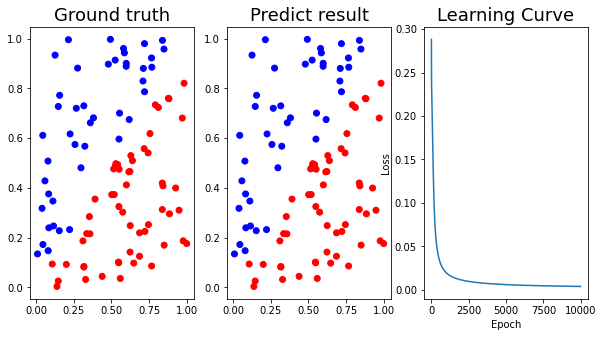

In [8]:
X, y = generate_linear(n=100)
# trian
model_linear = Model(n_neurons=4)
for epoch in range(EPOCH):
    y_pred = model_linear.forward(X)
    loss = MSE(y, y_pred)
    d_loss = derivative_loss(y, y_pred)
    g1, g2 = model_linear.backward(d_loss)
    model_linear.update()

    if epoch%500 == 0:
        print(f'epoch : {epoch} loss : {loss} ')
    history_linear.append((epoch, loss))

y_linear = model_linear.forward(X)
show_result(X, y, y_linear, history_linear)

#### Train & Predict X_OR Data

epoch : 0 loss : 0.31031025338431106 
epoch : 500 loss : 0.23933849912322627 
epoch : 1000 loss : 0.21469985529664348 
epoch : 1500 loss : 0.18656226335397733 
epoch : 2000 loss : 0.1023336401306771 
epoch : 2500 loss : 0.06472084162524376 
epoch : 3000 loss : 0.047019476848275774 
epoch : 3500 loss : 0.035706477946801235 
epoch : 4000 loss : 0.027395857336949984 
epoch : 4500 loss : 0.021131003449482023 
epoch : 5000 loss : 0.01646009836984113 
epoch : 5500 loss : 0.013014300703141336 
epoch : 6000 loss : 0.010473409006557036 
epoch : 6500 loss : 0.008583715431735826 
epoch : 7000 loss : 0.007158532281765117 
epoch : 7500 loss : 0.006065841589074477 
epoch : 8000 loss : 0.005213694580463523 
epoch : 8500 loss : 0.00453807223523973 
epoch : 9000 loss : 0.0039940441305174 
epoch : 9500 loss : 0.0035496857815375702 


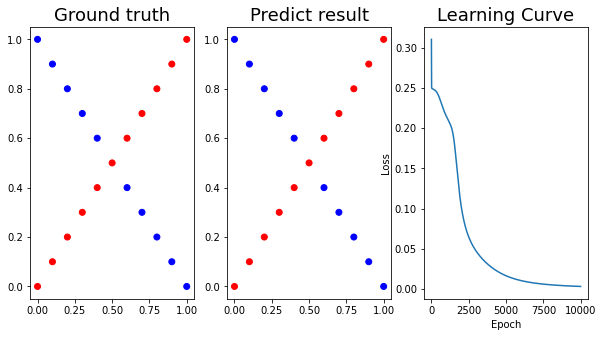

In [9]:
X_or, y_or = generate_XOR_easy()

# trian
model_xor = Model(n_neurons=4)
for epoch in range(EPOCH):
    y_pred = model_xor.forward(X_or)
    loss = MSE(y_or, y_pred)
    d_loss = derivative_loss(y_or, y_pred)
    g1, g2 = model_xor.backward(d_loss)
    model_xor.update()

    if epoch%500 == 0:
        print(f'epoch : {epoch} loss : {loss} ')

    history_XOR.append((epoch, loss))
y_linear = model_xor.forward(X_or)
show_result(X_or, y_or, y_linear, history_XOR)

# Discussion

## A. Try different learning rate

We can clearly observe that the speed of convergence is different, and the training process with a larger learning rate has a faster convergence speed. Learning rate is the parameter of gradient descent. $\theta^{1}=\theta^{0}-\eta\nabla L(\theta^{0})$. It can control the size of each step. If it is too large, it may reach the very best point, and the next step will be over, so it will not converge. If it is too slow, it will iterate many times before it converges.

In [10]:
def try_different_LR(LEARNING_RATE, history, idx):
    epoch = np.array([i[0] for i in history])
    loss = np.array([i[1] for i in history])
    plt.figure()
    plt.title(f'Learning Curve of LR={LEARNING_RATE}', fontsize=18)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epoch, loss)
    plt.show()
    return 0

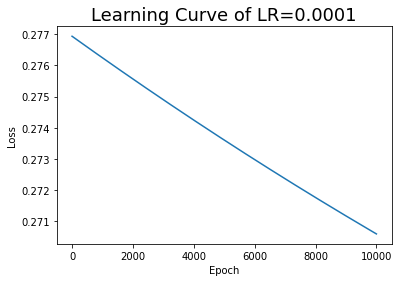

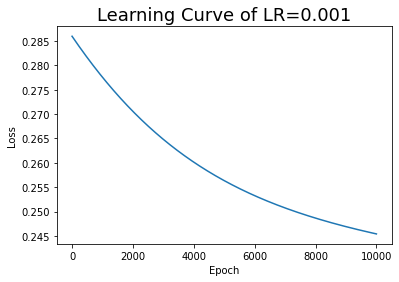

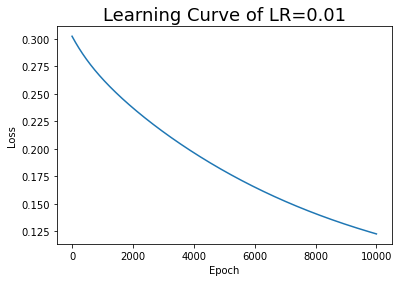

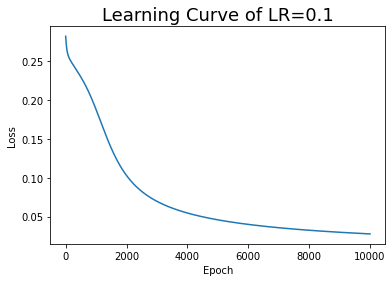

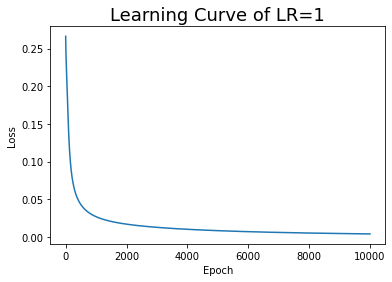

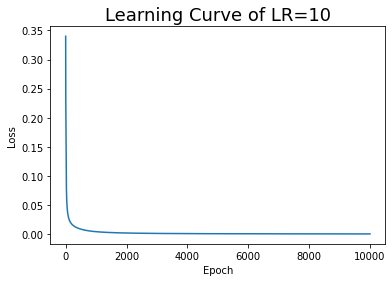

In [11]:
LR = [0.0001, 0.001, 0.01, 0.1, 1, 10]
X, y = generate_linear(n=100)
# trian
for idx, LEARNING_RATE in enumerate(LR):
    history_LR=[]
    model_linear = Model(n_neurons=4)
    for epoch in range(EPOCH):
        y_pred = model_linear.forward(X)
        loss = MSE(y, y_pred)
        d_loss = derivative_loss(y, y_pred)
        g1, g2 = model_linear.backward(d_loss)
        model_linear.update()
        history_LR.append((epoch, loss))

    y_linear = model_linear.forward(X)
    try_different_LR(LEARNING_RATE, history_LR, idx)

## B. Try different numbers of hidden units

I think it is most clearly felt that the training time increases with the number of neurons due to $z=w^Tx+b$ , it means that the more neurons we create the more matrix computation we need to do.  So I think the calculation time of forward will increase, but because the hidden design is too simple, and the precision of the timestamp is not enough, so I did not list the forward time

training time : 0.5953848361968994
prediction time :   0.0


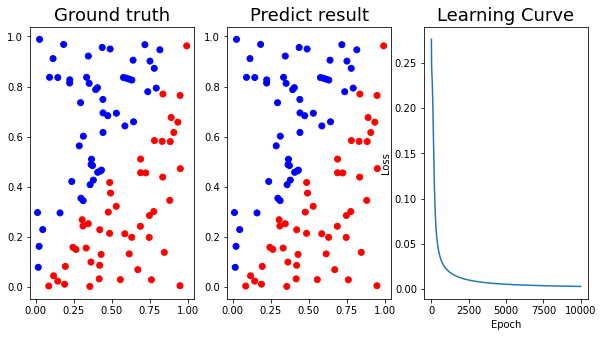

training time : 0.6680541038513184
prediction time :   0.0


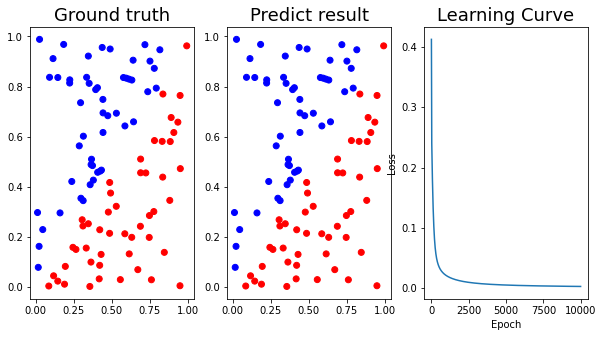

training time : 0.7725932598114014
prediction time :   0.0


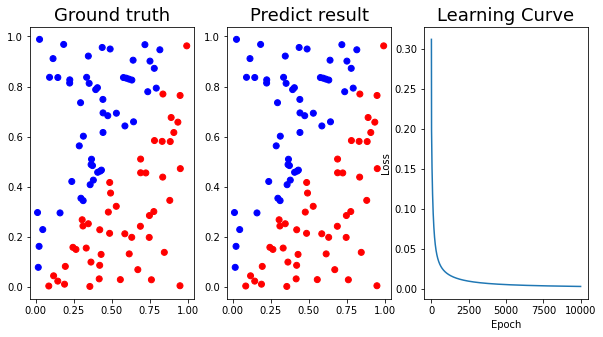

training time : 1.0165166854858398
prediction time :   0.0


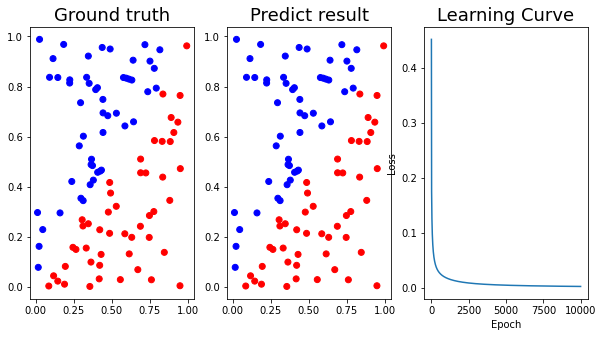

training time : 3.795274019241333
prediction time :   0.0009961128234863281


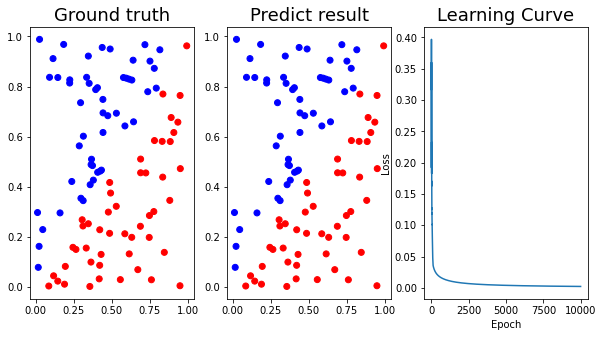

In [12]:
if __name__ == '__main__':
    EPOCH = 10000
    LEARNING_RATE = 1
    n_units = [4, 8, 16, 32, 128]
    X_B, y_B = generate_linear(n=100)
    import time
    # trian
    for idx,n_neurons in enumerate(n_units):
        history_B = []
        model_B = Model(n_neurons=n_neurons)
        start = time.time()
        for epoch in range(10000):
            y_pred_B = model_B.forward(X_B)
            loss_B = MSE(y_B, y_pred_B)
            d_loss_B = derivative_loss(y_B, y_pred_B)
            g1_B, g2_B = model_B.backward(d_loss_B)
            model_B.update()

            history_B.append((epoch, loss_B))
        end =time.time()
        f_time = time.time()
        y_pred_BB = model_B.forward(X_B)
        ff_time = time.time()
        print(f'training time : {end-start}')
        print('prediction time :  ', ff_time-f_time)
        show_result(X_B, y_B, y_pred_BB, history_B, idx)
